In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
class Firm:
    def __init__(self, roe=0.10, ti=0.19, ci=0.40, td=0.34, cd=0.25, tc=0.20):
        self.ti = ti * ci                 # Huojennettu perintövero-%
        self.tc = tc + (1 - tc) * td * cd # Integroitu osinkovero-%
        self.roe = roe                    # Oman pääoman tuotto-%    
        
        self.t = np.array([0])  # Vuotta kulunut sukupolvenvaihdoksesta
        self.a = np.array([10]) # Omaa pääomaa a(t)
        self.fill(20)

    @property
    def A(self): # Omaa pääomaa juuri, kun perintövero on saatu maksettua
        return self.a[10]

    def next(self): # Laske yksi vuosi eteenpäin
        t = self.t[-1] + 1
        a = self.a[-1] * (1 + self.roe)
        if t <= 10:
            p = (self.a[0] * self.ti) / 10 # Perintöveron tasaerä
            a -= p / (1 - self.tc)
        self.t = np.append(self.t, t)
        self.a = np.append(self.a, a)

    def fill(self, N=20): # Laske, kunnes laskettuna on N vuotta
        while len(self.t) < N:
            self.next()

    def inv(self, a): # Millä ajanhetkellä oman pääoman arvo on a?
        return np.interp(a, self.a, self.t)

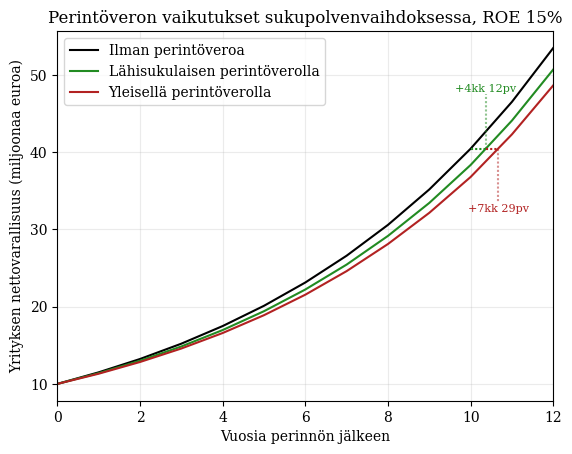

In [3]:
COLORS = ["black", "forestgreen", "firebrick"]
LABELS = ["Ilman perintöveroa", "Lähisukulaisen perintöverolla", "Yleisellä perintöverolla"]
DENSE = (0, (1, 1))

def loss_to_str(years):
    months = int(years * 12)
    days = int(np.round(years * 360 - months * 30))
    return f"+{months}kk {days}pv"

def annotate_loss(ax, x0, x, y, i, d):
    s = loss_to_str(x - 10)
    va = "top" if d < 0 else "bottom"
    ax.plot([x0, x], [y, y], color=COLORS[i], linestyle=DENSE)
    ax.plot([x, x], [y, y+d], color=COLORS[i], linestyle=DENSE, alpha=0.5)
    ax.text(x, y + d, s, va=va, ha="center", fontsize=8, color=COLORS[i])

def plot_fixed_roe(ax, roe, N):
    f0 = Firm(roe, 0.00)
    f1 = Firm(roe, 0.19)
    f2 = Firm(roe, 0.33)
    for i, f in enumerate([f0, f1, f2]):
        ax.plot(f.t[:N+1], f.a[:N+1], color=COLORS[i], label=LABELS[i])
    y = f0.A
    x1 = f1.inv(y)
    x2 = f2.inv(y)
    annotate_loss(ax, 10, x1, y, 1, +(y-5)/5)
    annotate_loss(ax, x1, x2, y, 2, -(y-5)/5)
    ax.set_xlim(0, N)
    ax.set_xlabel("Vuosia perinnön jälkeen")
    ax.set_ylabel("Yrityksen nettovarallisuus (miljoonaa euroa)")
    ax.set_title(f"Perintöveron vaikutukset sukupolvenvaihdoksessa, ROE {100*roe:.0f}%")
    ax.legend()

plt.figure()
plot_fixed_roe(plt.gca(), 0.15, 12)
plt.savefig("fig1.png")
plt.show()

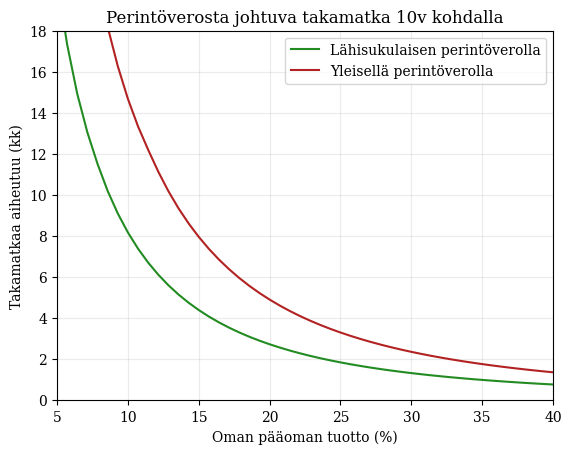

In [4]:
def loss(roe, ti): # Montako vuotta "takamatkaa" perintöverosta aiheutuu?
    f0 = Firm(roe, 0)
    f1 = Firm(roe, ti)
    return f1.inv(f0.A) - 10

def losses(roes): # Takamatka-sarjat eri oman pääoman tuottoprosenteilla
    l1 = np.array([loss(roe, 0.19) for roe in roes])
    l2 = np.array([loss(roe, 0.33) for roe in roes])
    return l1, l2

def plot_per_roe(ax, roes):
    l1, l2 = losses(roes)
    ax.plot(100 * roes, 12 * l1, color=COLORS[1], label=LABELS[1])
    ax.plot(100 * roes, 12 * l2, color=COLORS[2], label=LABELS[2])
    ax.set_xlim(100 * roes[0], 100 * roes[-1])
    ax.set_ylim(0, 18)
    ax.set_xlabel("Oman pääoman tuotto (%)")
    ax.set_ylabel("Takamatkaa aiheutuu (kk)")
    ax.set_title("Perintöverosta johtuva takamatka 10v kohdalla")
    ax.legend()

plt.figure()
plot_per_roe(plt.gca(), np.linspace(0.05, 0.40))
plt.savefig("fig2.png")
plt.show()

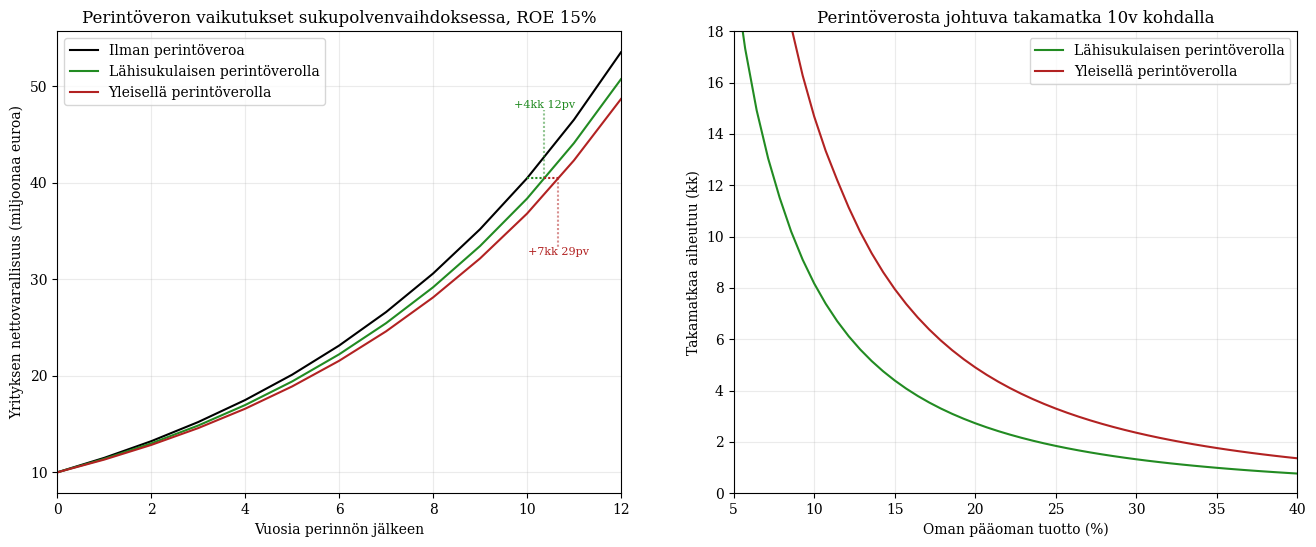

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_fixed_roe(ax[0], 0.15, 12)
plot_per_roe(ax[1], np.linspace(0.05, 0.40))
plt.savefig("fig3.png")
plt.show()